# Unit 5 - Financial Planning

In [1]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [2]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [3]:
# Set current amount of crypto assets
my_btc = 1.2
my_eth = 5.3

In [4]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [5]:
# Fetch current BTC price
btc_response_data = requests.get(btc_url)
btc_data = btc_response_data.json()
btc_price = btc_data["data"]["1"]["quotes"]["CAD"]["price"]

# Fetch current ETH price
eth_response_data = requests.get(eth_url)
eth_data = eth_response_data.json()
eth_price = eth_data["data"]["1027"]["quotes"]["CAD"]["price"]

# Compute current value of my crpto
my_btc_value = my_btc * btc_price
my_eth_value = my_eth * eth_price

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f} CAD")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f} CAD")

The current value of your 1.2 BTC is $42124.37 CAD
The current value of your 5.3 ETH is $12510.59 CAD


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [6]:
# Set current amount of shares
my_agg = 200
my_spy = 50

In [7]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv('ALPACA_API_KEY')
alpaca_secret_key = os.getenv('ALPACA_SECRET_KEY')

# Create the Alpaca API object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "V2")

In [8]:
# Format current date as ISO format
today = pd.Timestamp("2023-06-12", tz = "America/New_York").isoformat()

# Set the tickers
tickers = ["AGG", "SPY"]

# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

# Get current closing prices for SPY and AGG
portfolio_df = alpaca.get_bars(
    tickers,
    timeframe,
    start = today,
    end = today
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = portfolio_df[portfolio_df['symbol'] == 'AGG'].drop('symbol', axis = 'columns')
SPY = portfolio_df[portfolio_df['symbol'] == 'SPY'].drop('symbol', axis = 'columns')

# Concatenate the ticker DataFrames
portfolio_df = pd.concat([AGG, SPY], axis = 'columns', keys = ['AGG', 'SPY'])

# Preview DataFrame
portfolio_df

AGG                                            \
                            open   high    low  close   volume trade_count   
timestamp                                                                    
2023-06-12 04:00:00+00:00  98.09  98.16  97.73  98.14  5382618       23870   

                                         SPY                                   \
                                vwap    open    high     low  close    volume   
timestamp                                                                       
2023-06-12 04:00:00+00:00  97.960799  430.92  433.86  430.17  433.8  73919398   

                                                   
                          trade_count        vwap  
timestamp                                          
2023-06-12 04:00:00+00:00      513237  431.921234

In [9]:
# Pick AGG and SPY close prices
agg_close_price = float(portfolio_df["AGG"]["close"])
spy_close_price = float(portfolio_df["SPY"]["close"])

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $98.14
Current SPY closing price: $433.8


In [10]:
# Compute the current value of shares
my_agg_value = my_agg * agg_close_price
my_spy_value = my_spy * spy_close_price

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50 SPY shares is $21690.00
The current value of your 200 AGG shares is $19628.00


### Savings Health Analysis

In [11]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
assets_data = {
    "amount": {
        "crypto": my_btc_value + my_eth_value,
        "shares": my_agg_value + my_spy_value
    }
}

# Create savings DataFrame
savings_df = pd.DataFrame(assets_data)

# Display savings DataFrame
display(savings_df)

amount
crypto  54634.958878
shares  41318.000000

<Axes: title={'center': 'Personal Savings Composition'}, ylabel='amount'>

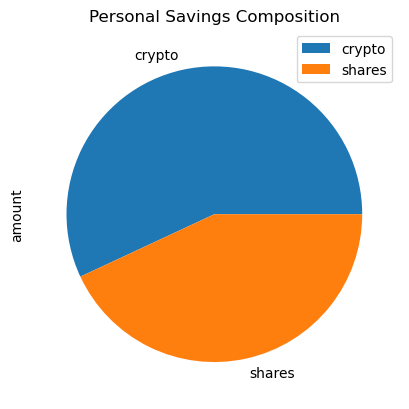

In [12]:
# Plot savings pie chart
savings_df.plot.pie(y = "amount", title = "Personal Savings Composition")

In [13]:
# Calculate total amount of savings
total_savings_amount = float(savings_df.loc["crypto"] + savings_df.loc["shares"])

# Validate saving health
def validate_saving_health(savings_amount, monthly_income):
    """
    Validates whether or not the total savings amount is sufficient
    for an emergency fund.
    Args:
        savings_amount (float): The total savings amount
        monthly_income (float): The total monthly income
    Returns:
        str: A message validating the saving health 
    """
    # Set ideal emergency fund
    emergency_fund = monthly_income * 3
    
    # Check the total savings amount with the ideal emergency fund and
    # return a corresponding message
    if savings_amount > emergency_fund:
        message = "Congratulations! You have enough money in your emergency fund."
    elif savings_amount == emergency_fund:
        message = "Congratulations! You have reached the financial goal of an emergency fund."
    else:
        difference = emergency_fund - savings_amount
        message = f"Keep it up! You are only ${difference} away from reaching the goal of an emergency fund."
    
    return message

print(validate_saving_health(total_savings_amount, monthly_income))

Congratulations! You have enough money in your emergency fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [14]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2018-06-12', tz = 'America/New_York').isoformat()
end_date = pd.Timestamp('2023-06-12', tz = 'America/New_York').isoformat()

In [15]:
# Get 5 years' worth of historical data for SPY and AGG
stock_data_df = alpaca.get_bars(
    tickers,
    timeframe,
    start = start_date,
    end = end_date
).df

# Reorganize the DataFrame
# Separate ticker data
AGG = stock_data_df[stock_data_df['symbol'] == 'AGG'].drop('symbol', axis = 'columns')
SPY = stock_data_df[stock_data_df['symbol'] == 'SPY'].drop('symbol', axis = 'columns')


# Concatenate the ticker DataFrames
stock_data_df = pd.concat([AGG, SPY], axis = 'columns', keys = ['AGG', 'SPY'])

# Display sample data
stock_data_df.head()

AGG                                     \
                             open     high      low   close   volume   
timestamp                                                              
2018-06-12 04:00:00+00:00  105.56  105.690  105.560  105.67  3546472   
2018-06-13 04:00:00+00:00  105.68  105.750  105.380  105.57  3627830   
2018-06-14 04:00:00+00:00  105.75  105.860  105.691  105.84  4689627   
2018-06-15 04:00:00+00:00  106.01  106.089  105.860  105.88  2361854   
2018-06-18 04:00:00+00:00  105.93  105.930  105.800  105.90  2359452   

                                                      SPY                    \
                          trade_count        vwap    open    high       low   
timestamp                                                                     
2018-06-12 04:00:00+00:00       10209  105.641868  279.03  279.33  278.1900   
2018-06-13 04:00:00+00:00       12403  105.601123  279.19  279.48  277.8000   
2018-06-14 04:00:00+00:00       16198  105.765441  279.01  279.33  278.0599   
2018-06-15 04:00:00+00:00       12759  105.936682  276.61  277.51  275.3500   
2018-06-18 04:00:00+00:00       10590  105.864382  275.49  276.70  274.9500   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2018-06-12 04:00:00+00:00  278.97   72984124      211612  278.826095  
2018-06-13 04:00:00+00:00  278.01   79378117      275306  278.685416  
2018-06-14 04:00:00+00:00  278.68   77667620      233427  278.670576  
2018-06-15 04:00:00+00:00  277.03  120673012      305807  276.757012  
2018-06-18 04:00:00+00:00  276.59   53163695      221103  276.151288

In [16]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_year = MCSimulation(
    portfolio_data = stock_data_df,
    weights = [0.40, 0.60],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [17]:
# Printing the simulation input data
MC_thirty_year.portfolio_data.head()

AGG                                     \
                             open     high      low   close   volume   
timestamp                                                              
2018-06-12 04:00:00+00:00  105.56  105.690  105.560  105.67  3546472   
2018-06-13 04:00:00+00:00  105.68  105.750  105.380  105.57  3627830   
2018-06-14 04:00:00+00:00  105.75  105.860  105.691  105.84  4689627   
2018-06-15 04:00:00+00:00  106.01  106.089  105.860  105.88  2361854   
2018-06-18 04:00:00+00:00  105.93  105.930  105.800  105.90  2359452   

                                                                   SPY  \
                          trade_count        vwap daily_return    open   
timestamp                                                                
2018-06-12 04:00:00+00:00       10209  105.641868          NaN  279.03   
2018-06-13 04:00:00+00:00       12403  105.601123    -0.000946  279.19   
2018-06-14 04:00:00+00:00       16198  105.765441     0.002558  279.01   
2018-06-15 04:00:00+00:00       12759  105.936682     0.000378  276.61   
2018-06-18 04:00:00+00:00       10590  105.864382     0.000189  275.49   

                                                                            \
                             high       low   close     volume trade_count   
timestamp                                                                    
2018-06-12 04:00:00+00:00  279.33  278.1900  278.97   72984124      211612   
2018-06-13 04:00:00+00:00  279.48  277.8000  278.01   79378117      275306   
2018-06-14 04:00:00+00:00  279.33  278.0599  278.68   77667620      233427   
2018-06-15 04:00:00+00:00  277.51  275.3500  277.03  120673012      305807   
2018-06-18 04:00:00+00:00  276.70  274.9500  276.59   53163695      221103   

                                                    
                                 vwap daily_return  
timestamp                                           
2018-06-12 04:00:00+00:00  278.826095          NaN  
2018-06-13 04:00:00+00:00  278.685416    -0.003441  
2018-06-14 04:00:00+00:00  278.670576     0.002410  
2018-06-15 04:00:00+00:00  276.757012    -0.005921  
2018-06-18 04:00:00+00:00  276.151288    -0.001588

In [18]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirty_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4          5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000   1.000000  1.000000   
1     0.998471  0.993413  1.000638  1.002481  0.992578   1.002296  0.995845   
2     0.995097  0.985140  1.006896  1.004975  0.991799   1.004405  1.000165   
3     0.987764  0.980305  1.010410  0.997813  0.994894   0.999897  0.990543   
4     0.976732  0.966547  1.017836  0.996338  0.986034   0.998474  0.986212   
...        ...       ...       ...       ...       ...        ...       ...   
7556  2.206479  7.942455  4.043839  2.333073  2.487021  11.141088  2.693628   
7557  2.168666  7.961799  4.017204  2.334767  2.472000  11.310687  2.719709   
7558  2.154986  8.001463  4.034186  2.363489  2.486099  11.193670  2.692455   
7559  2.164582  7.915720  4.068347  2.377113  2.469566  11.052689  2.694692   
7560  2.183840  7.892211  4.068489  2.365730  2.478537  11.034801  2.693526   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.994688  1.002755  1.005754  ...  0.988356  0.989917  0.999227   
2     0.996385  1.002097  1.004036  ...  0.978492  0.993235  1.006769   
3     0.990213  0.998235  1.017079  ...  0.970653  1.004107  1.001673   
4     0.976235  1.008173  1.022501  ...  0.960355  0.994724  0.998366   
...        ...       ...       ...  ...       ...       ...       ...   
7556  3.261120  6.122254  4.839630  ...  3.989708  3.420287  6.000075   
7557  3.252792  6.122662  4.879507  ...  4.055170  3.425404  6.021292   
7558  3.270872  6.058493  4.881659  ...  4.020685  3.409924  5.942555   
7559  3.310897  5.957925  4.855263  ...  4.082163  3.410117  5.930483   
7560  3.293805  5.956299  4.752879  ...  4.069813  3.420358  5.874086   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.992142  0.995301  0.991291  1.004505  0.983811  1.003028  0.998218  
2     0.989992  0.990622  0.988769  1.005995  0.983059  1.006185  1.013068  
3     0.999722  0.981557  0.989352  1.006478  0.984528  1.000606  1.010829  
4     0.989681  0.980101  0.980482  0.995535  0.991698  0.988200  1.008919  
...        ...       ...       ...       ...       ...       ...       ...  
7556  4.621703  4.586095  4.440103  1.746563  5.334719  6.414375  3.503749  
7557  4.646623  4.612544  4.455349  1.763795  5.387306  6.376147  3.543343  
7558  4.630002  4.668187  4.436588  1.759567  5.355676  6.422165  3.521080  
7559  4.746099  4.650331  4.389939  1.764753  5.377418  6.448502  3.495254  
7560  4.789881  4.651257  4.418898  1.733838  5.456713  6.492380  3.444650  

[7561 rows x 500 columns]

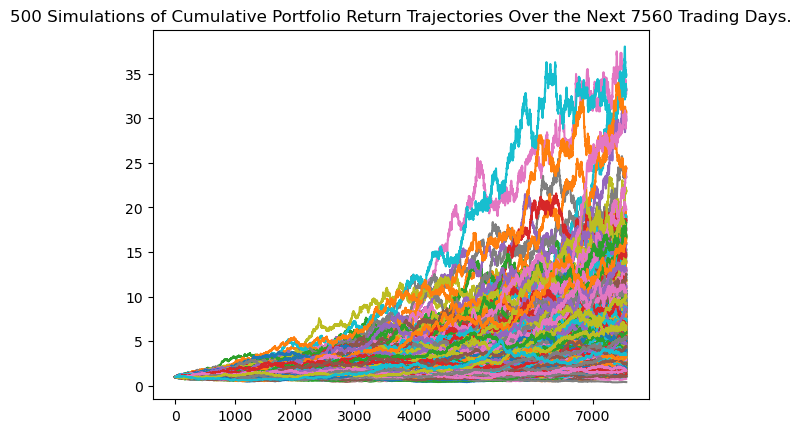

In [19]:
# Plot simulation outcomes
line_plot = MC_thirty_year.plot_simulation()

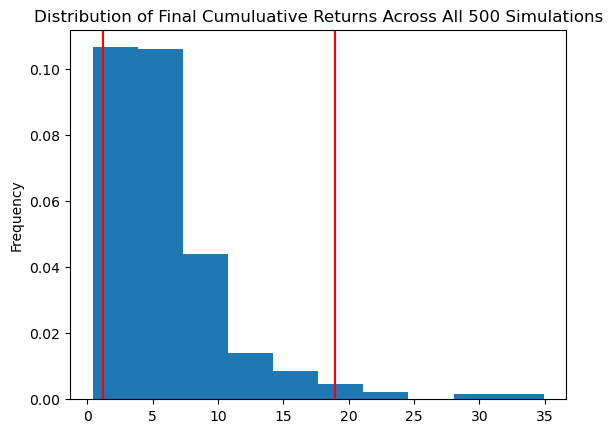

In [20]:
# Plot probability distribution and confidence intervals
dist_plot = MC_thirty_year.plot_distribution()

### Retirement Analysis

In [21]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl = MC_thirty_year.summarize_cumulative_return()

# Print summary statistics
print(tbl)

count           500.000000
mean              6.149160
std               4.991747
min               0.410167
25%               2.868031
50%               4.876604
75%               7.680945
max              34.924823
95% CI Lower      1.207368
95% CI Upper     18.917651
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [22]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $24147.36 and $378353.03


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [23]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(tbl[8]*initial_investment,2)
ci_upper = round(tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $36221.04 and $567529.54


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [24]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_year = MCSimulation(
    portfolio_data = stock_data_df,
    weights = [0.10, 0.90],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [25]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_five_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.991464  0.998253  1.016784  0.992509  1.020730  1.011598  1.012234   
2     0.993758  1.015466  1.031019  1.012360  1.001296  1.008268  1.022868   
3     0.995542  1.002754  1.023727  1.023331  1.023463  1.024996  1.042021   
4     1.002757  1.006845  1.024496  1.051063  1.016319  1.036662  1.032505   
...        ...       ...       ...       ...       ...       ...       ...   
1256  1.038642  1.621937  1.646134  1.331453  1.265156  1.964136  2.377317   
1257  1.039970  1.620460  1.614725  1.345318  1.243073  1.958533  2.354832   
1258  1.056655  1.628406  1.606637  1.342892  1.241446  1.957387  2.345470   
1259  1.046677  1.613150  1.593571  1.350183  1.255903  1.973334  2.349667   
1260  1.056744  1.609776  1.577433  1.354775  1.241953  1.943745  2.336801   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     1.009311  0.998668  1.003426  ...  1.000330  1.002594  1.028203   
2     1.013092  1.004521  0.986905  ...  1.012767  0.996658  1.039247   
3     1.012848  1.015779  0.983419  ...  0.998331  0.982958  1.045605   
4     1.006263  1.020928  0.971758  ...  1.009046  0.978298  1.061333   
...        ...       ...       ...  ...       ...       ...       ...   
1256  1.932952  2.473372  0.911363  ...  2.573310  0.577645  1.322798   
1257  1.968877  2.507242  0.908602  ...  2.636476  0.576777  1.330727   
1258  1.955783  2.488488  0.897722  ...  2.646842  0.565256  1.317708   
1259  1.970823  2.493613  0.878646  ...  2.680228  0.564594  1.313774   
1260  1.991155  2.472044  0.860559  ...  2.714587  0.556911  1.325468   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     1.004678  0.979395  0.998088  0.996036  0.996956  0.995412  0.990658  
2     0.981398  0.958543  1.007701  1.000243  1.000404  0.999163  0.982196  
3     0.998344  0.952336  1.014969  0.980749  1.012125  1.028702  0.987965  
4     0.988682  0.954617  1.021549  0.973427  1.022063  1.026458  0.976158  
...        ...       ...       ...       ...       ...       ...       ...  
1256  2.187459  1.310662  1.291233  1.265698  2.193412  0.769723  0.932029  
1257  2.210246  1.341335  1.295536  1.259187  2.201845  0.770174  0.923323  
1258  2.183881  1.335872  1.304035  1.299283  2.217362  0.770062  0.922888  
1259  2.137522  1.360829  1.297513  1.304435  2.173133  0.769294  0.923289  
1260  2.129041  1.374015  1.306391  1.288901  2.167005  0.784034  0.927580  

[1261 rows x 500 columns]

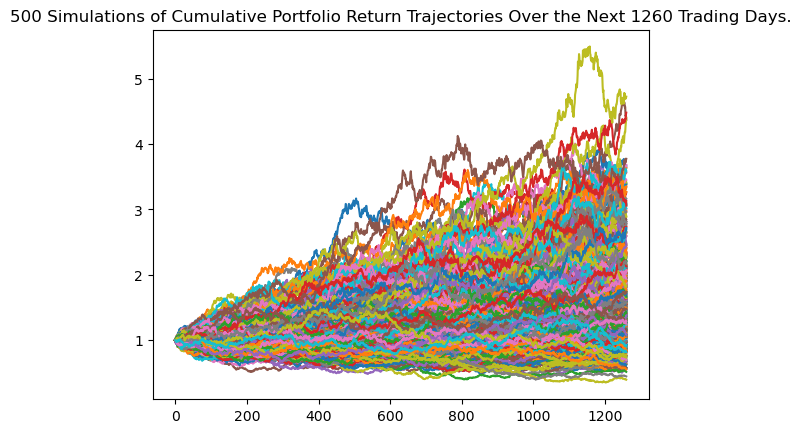

In [26]:
# Plot simulation outcomes
line_plot_five = MC_five_year.plot_simulation()

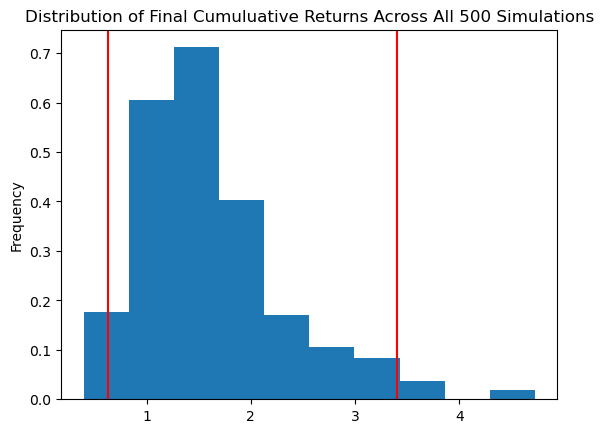

In [27]:
# Plot probability distribution and confidence intervals
dist_plot_five = MC_five_year.plot_distribution()

In [28]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_five = MC_five_year.summarize_cumulative_return()

# Print summary statistics
print(tbl_five)

count           500.000000
mean              1.621603
std               0.710596
min               0.398339
25%               1.146883
50%               1.469383
75%               1.983289
max               4.725456
95% CI Lower      0.633746
95% CI Upper      3.403647
Name: 1260, dtype: float64


In [29]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(tbl_five[8]*initial_investment,2)
ci_upper_five = round(tbl_five[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $38024.75 and $204218.8


### Ten Years Retirement Option

In [30]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year = MCSimulation(
    portfolio_data = stock_data_df,
    weights = [0.20, 0.80],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [31]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_ten_year.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1         2         3         4         5         6    \
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
1     0.989641  0.994621  1.007795  1.012112  0.990739  0.998640  0.997526   
2     0.994218  0.989031  1.000199  1.020897  0.979227  1.007336  0.998467   
3     1.005786  0.993521  0.987525  1.033902  0.977199  1.020147  1.024024   
4     1.014082  0.995600  0.976243  1.034127  0.979621  1.043664  1.029223   
...        ...       ...       ...       ...       ...       ...       ...   
2516  5.270556  2.463008  1.236016  1.384005  2.697247  1.410187  2.610986   
2517  5.219082  2.434064  1.205389  1.376746  2.677292  1.412938  2.616948   
2518  5.251102  2.460097  1.185808  1.378908  2.670888  1.387420  2.587815   
2519  5.180463  2.441276  1.178106  1.394917  2.684925  1.395537  2.577304   
2520  5.251088  2.410156  1.169775  1.398478  2.719544  1.420463  2.578098   

           7         8         9    ...       490       491       492  \
0     1.000000  1.000000  1.000000  ...  1.000000  1.000000  1.000000   
1     0.991863  0.989433  1.008236  ...  1.009060  1.002412  1.009641   
2     0.992279  0.985376  1.013933  ...  0.999819  0.995253  1.009104   
3     0.989196  0.991405  1.023683  ...  1.003191  0.998922  0.998865   
4     0.999051  0.962769  1.031793  ...  1.014559  1.006332  1.001343   
...        ...       ...       ...  ...       ...       ...       ...   
2516  2.561632  1.486398  1.188698  ...  4.213226  1.495867  6.580308   
2517  2.552037  1.479488  1.189529  ...  4.245974  1.506465  6.562846   
2518  2.512069  1.488159  1.185115  ...  4.263278  1.494810  6.625236   
2519  2.489112  1.514221  1.201031  ...  4.243584  1.506183  6.614288   
2520  2.453139  1.535955  1.204022  ...  4.295222  1.463609  6.572750   

           493       494       495       496       497       498       499  
0     1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
1     0.997955  1.019913  0.995170  0.996003  1.012242  1.006374  0.997744  
2     0.996681  1.001379  0.983579  0.996524  1.012173  1.015438  1.002269  
3     0.983703  0.976991  0.990381  0.988561  0.999685  1.017983  1.019335  
4     0.978815  0.968263  0.994562  0.992635  1.004471  1.047373  1.012956  
...        ...       ...       ...       ...       ...       ...       ...  
2516  3.140683  1.825677  0.358589  3.404925  3.051276  3.370400  1.132524  
2517  3.185689  1.838970  0.356159  3.386001  3.008951  3.467470  1.129037  
2518  3.163674  1.870023  0.358167  3.420339  3.015922  3.431611  1.131494  
2519  3.180372  1.857531  0.358918  3.445794  2.997221  3.488959  1.144826  
2520  3.124071  1.896969  0.356330  3.463226  2.943597  3.435133  1.146494  

[2521 rows x 500 columns]

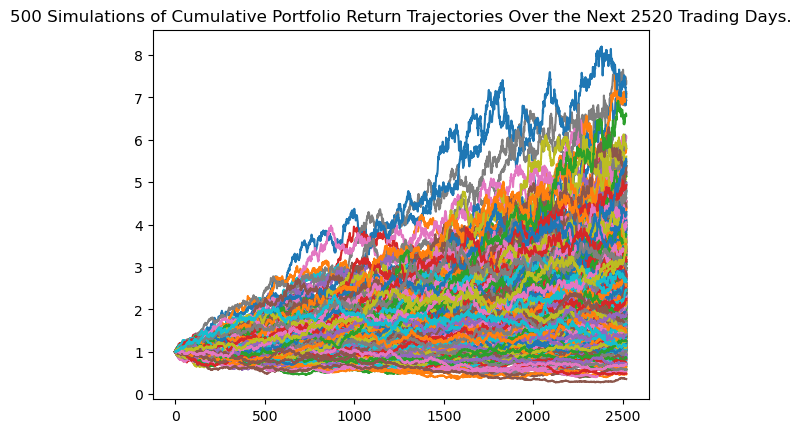

In [32]:
# Plot simulation outcomes
line_plot_ten = MC_ten_year.plot_simulation()

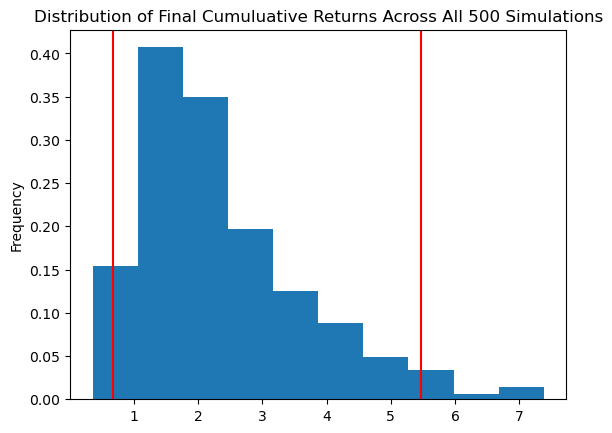

In [33]:
# Plot probability distribution and confidence intervals
dist_plot_ten = MC_ten_year.plot_distribution()

In [34]:
# Fetch summary statistics from the Monte Carlo simulation results
tbl_ten = MC_ten_year.summarize_cumulative_return()

# Print summary statistics
print(tbl_ten)

count           500.000000
mean              2.361424
std               1.293239
min               0.356330
25%               1.412160
50%               2.060436
75%               2.995019
max               7.381823
95% CI Lower      0.676823
95% CI Upper      5.464493
Name: 2520, dtype: float64


In [35]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(tbl_ten[8]*initial_investment,2)
ci_upper_ten = round(tbl_ten[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $40609.36 and $327869.58


# Contributor
Andy Vu